Outline

    load data
    initialization
        load 1D array of data (X, Y, W)
        create 1D array of agents (X, Y, angle, W)
        create 2D trace grid (empty)
        create 2D dual deposit grid (empty)
    simulation
        update state
        draw GUI
        process data (kernel inputs: data, deposit)
        propagation step (kernel inputs: agents, trace, deposit)
        relaxation step (kernel inputs: deposit)
        relaxation step (kernel inputs: trace)
        generate visualization (kernel inputs: deposit, trace, vis buffer)
        update GUI
    store grids
    tidy up

In [1]:
import numpy as np
import math, os
from enum import IntEnum
from numpy.random import default_rng
import time
from datetime import datetime
import matplotlib.pyplot as plt
import taichi as ti
import taichi.math as timath

## Type aliases
FLOAT_CPU = np.float32
INT_CPU = np.int32
FLOAT_GPU = ti.f32
INT_GPU = ti.i32

VEC2i = ti.types.vector(2, INT_GPU)
VEC3i = ti.types.vector(3, INT_GPU)
VEC2f = ti.types.vector(2, FLOAT_GPU)
VEC3f = ti.types.vector(3, FLOAT_GPU)

## Distance sampling distribution for agents
class EnumDistanceSamplingDistribution(IntEnum):
    CONSTANT = 0
    EXPONENTIAL = 1
    MAXWELL_BOLTZMANN = 2

## Directional sampling distribution for agents
class EnumDirectionalSamplingDistribution(IntEnum):
    DISCRETE = 0
    CONE = 1

## Sampling strategy for directional agent mutation
class EnumDirectionalMutationType(IntEnum):
    DETERMINISTIC = 0
    PROBABILISTIC = 1

## Deposit fetching strategy
class EnumDepositFetchingStrategy(IntEnum):
    NN = 0
    NN_PERTURBED = 1

## Handling strategy for agents that leave domain boundary
class EnumAgentBoundaryHandling(IntEnum):
    WRAP = 0
    REINIT_CENTER = 1
    REINIT_RANDOMLY = 2

[Taichi] version 1.4.1, llvm 15.0.5, commit e67c674e, osx, python 3.8.13
[I 03/01/23 10:54:13.860 9833894] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [17]:
## Default root directory
ROOT = '../../'

## Data input file - leave empty for random set
# INPUT_FILE = ''
INPUT_FILE = ROOT + 'data/csv/sample_2D_logW.csv'
# INPUT_FILE = ROOT + 'data/csv/sample_2D_logW.csv'

## Simulation-wide constants
N_DATA_DEFAULT = 1000
N_AGENTS_DEFAULT = 1000000
DOMAIN_SIZE_DEFAULT = (100.0, 100.0)
TRACE_RESOLUTION_MAX = 1400
DEPOSIT_DOWNSCALING_FACTOR = 1
STEERING_RATE = 0.5
MAX_DEPOSIT = 10.0
DOMAIN_MARGIN = 0.05

## State flags
distance_sampling_distribution = EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN
directional_sampling_distribution = EnumDirectionalSamplingDistribution.CONE
directional_mutation_type = EnumDirectionalMutationType.PROBABILISTIC
deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED
agent_boundary_handling = EnumAgentBoundaryHandling.WRAP

In [18]:
## Initialize Taichi
ti.init(arch=ti.cpu, dynamic_index=True)
rng = default_rng()

## Initialize data and agents
data = None
DOMAIN_MIN = None
DOMAIN_MAX = None
DOMAIN_SIZE = None
N_DATA = None
N_AGENTS = None
AVG_WEIGHT = 10.0

## Load data
## If no input file then generate a random dataset
if len(INPUT_FILE) > 0:
    data = np.loadtxt(INPUT_FILE, delimiter=",").astype(FLOAT_CPU)
    N_DATA = data.shape[0]
    N_AGENTS = N_AGENTS_DEFAULT
    domain_min = (np.min(data[:,0]), np.min(data[:,1]))
    domain_max = (np.max(data[:,0]), np.max(data[:,1]))
    domain_size = np.subtract(domain_max, domain_min)
    DOMAIN_MIN = (domain_min[0] - DOMAIN_MARGIN * domain_size[0], domain_min[1] - DOMAIN_MARGIN * domain_size[1])
    DOMAIN_MAX = (domain_max[0] + DOMAIN_MARGIN * domain_size[0], domain_max[1] + DOMAIN_MARGIN * domain_size[1])
    DOMAIN_SIZE = np.subtract(DOMAIN_MAX, DOMAIN_MIN)
    AVG_WEIGHT = np.mean(data[:,2])
else:
    N_DATA = N_DATA_DEFAULT
    N_AGENTS = N_AGENTS_DEFAULT
    DOMAIN_SIZE = DOMAIN_SIZE_DEFAULT
    DOMAIN_MIN = (0.0, 0.0)
    DOMAIN_MAX = DOMAIN_SIZE_DEFAULT
    data = np.zeros(shape=(N_DATA, 3), dtype = FLOAT_CPU)
    data[:, 0] = rng.normal(loc = DOMAIN_MIN[0] + 0.5 * DOMAIN_MAX[0], scale = 0.13 * DOMAIN_SIZE[0], size = N_DATA)
    data[:, 1] = rng.normal(loc = DOMAIN_MIN[1] + 0.5 * DOMAIN_MAX[1], scale = 0.13 * DOMAIN_SIZE[1], size = N_DATA)
    data[:, 2] = AVG_WEIGHT

## Derived constants
DATA_TO_AGENTS_RATIO = FLOAT_CPU(N_DATA) / FLOAT_CPU(N_AGENTS)
DOMAIN_SIZE_MAX = np.max([DOMAIN_SIZE[0], DOMAIN_SIZE[1]])
TRACE_RESOLUTION = INT_CPU((FLOAT_CPU(TRACE_RESOLUTION_MAX) * DOMAIN_SIZE[0] / DOMAIN_SIZE_MAX, FLOAT_CPU(TRACE_RESOLUTION_MAX) * DOMAIN_SIZE[1] / DOMAIN_SIZE_MAX))
DEPOSIT_RESOLUTION = (TRACE_RESOLUTION[0] // DEPOSIT_DOWNSCALING_FACTOR, TRACE_RESOLUTION[1] // DEPOSIT_DOWNSCALING_FACTOR)
VIS_RESOLUTION = TRACE_RESOLUTION

## Init agents
agents = np.zeros(shape=(N_AGENTS, 4), dtype = FLOAT_CPU)
agents[:, 0] = rng.uniform(low = DOMAIN_MIN[0] + 0.001, high = DOMAIN_MAX[0] - 0.001, size = N_AGENTS)
agents[:, 1] = rng.uniform(low = DOMAIN_MIN[1] + 0.001, high = DOMAIN_MAX[1] - 0.001, size = N_AGENTS)
agents[:, 2] = rng.uniform(low = 0.0, high = 2.0 * np.pi, size = N_AGENTS)
agents[:, 3] = 1.0

print('Simulation domain min:', DOMAIN_MIN)
print('Simulation domain max:', DOMAIN_MAX)
print('Simulation domain size:', DOMAIN_SIZE)
print('Trace grid resolution:', TRACE_RESOLUTION)
print('Deposit grid resolution:', DEPOSIT_RESOLUTION)
print('Data sample:', data[0, :])
print('Agent sample:', agents[0, :])
print('Number of agents:', N_AGENTS)
print('Number of data points:', N_DATA)

GLFW Error 65537: The GLFW library is not initialized
[Taichi] Starting on arch=x64
Simulation domain min: (-457.9745269775391, -497.59637451171875)
Simulation domain max: (445.08982238769534, 6.09272575378418)
Simulation domain size: [903.06434937 503.68910027]
Trace grid resolution: [1400  780]
Deposit grid resolution: (1400, 780)
Data sample: [ -97.13328 -316.2591     9.86913]
Agent sample: [ 128.03435   -345.8797       1.1665783    1.       ]
Number of agents: 1000000
Number of data points: 10000


In [19]:
## Allocate GPU memory fields
## Keep in mind that the dimensions of these fields are important in the subsequent computations;
## that means if they change the GPU kernels and the associated handling code must be modified as well
data_field = ti.Vector.field(n = 3, dtype = FLOAT_GPU, shape = N_DATA)
agents_field = ti.Vector.field(n = 4, dtype = FLOAT_GPU, shape = N_AGENTS)
deposit_field = ti.Vector.field(n = 2, dtype = FLOAT_GPU, shape = DEPOSIT_RESOLUTION)
trace_field = ti.Vector.field(n = 1, dtype = FLOAT_GPU, shape = TRACE_RESOLUTION)
vis_field = ti.Vector.field(n = 3, dtype = FLOAT_GPU, shape = VIS_RESOLUTION)
print('Total GPU memory allocated:', INT_CPU(4 * (\
    data_field.shape[0] * 3 + \
    agents_field.shape[0] * 4 + \
    deposit_field.shape[0] * deposit_field.shape[1] * 2 + \
    trace_field.shape[0] * trace_field.shape[1] * 1 + \
    vis_field.shape[0] * vis_field.shape[1] * 3 \
    ) / 2 ** 20), 'MB')

Total GPU memory allocated: 40 MB


In [20]:
## Define all GPU functions and kernels for data and agent processing
@ti.kernel
def zero_field(f: ti.template()):
    for cell in ti.grouped(f):
        f[cell].fill(0.0)
    return

@ti.kernel
def copy_field(dst: ti.template(), src: ti.template()): 
    for cell in ti.grouped(dst):
        dst[cell] = src[cell]
    return

@ti.func
def world_to_grid_2D(pos_world, domain_min, domain_max, grid_resolution) -> VEC2i:
    pos_relative = (pos_world - domain_min) / (domain_max - domain_min)
    grid_coord = ti.cast(pos_relative * ti.cast(grid_resolution, FLOAT_GPU), INT_GPU)
    return ti.max(VEC2i(0, 0), ti.min(grid_coord, grid_resolution - (1, 1)))

@ti.func
def angle_to_dir_2D(angle) -> VEC2f:
    return timath.normalize(VEC2f(ti.cos(angle), ti.sin(angle)))

@ti.func
def custom_mod(a, b) -> FLOAT_GPU:
    return a - b * ti.floor(a / b)

@ti.kernel
def data_step(data_deposit: FLOAT_GPU, current_deposit_index: INT_GPU):
    for point in ti.ndrange(data_field.shape[0]):
        pos = VEC2f(0.0, 0.0)
        pos[0], pos[1], weight = data_field[point]
        deposit_cell = world_to_grid_2D(pos, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += data_deposit * weight
    return

@ti.kernel
def agent_step(sense_distance: FLOAT_GPU,\
               sense_angle: FLOAT_GPU,\
               steering_rate: FLOAT_GPU,\
               sampling_exponent: FLOAT_GPU,\
               step_size: FLOAT_GPU,\
               agent_deposit: FLOAT_GPU,\
               current_deposit_index: INT_GPU,\
               distance_sampling_distribution: INT_GPU,\
               directional_sampling_distribution: INT_GPU,\
               directional_mutation_type: INT_GPU,\
               deposit_fetching_strategy: INT_GPU,\
               agent_boundary_handling: INT_GPU):
    for agent in ti.ndrange(agents_field.shape[0]):
        pos = VEC2f(0.0, 0.0)
        pos[0], pos[1], angle, weight = agents_field[agent]
        
        ## Generate new mutated angle by perturbing the original
        dir_fwd = angle_to_dir_2D(angle)
        angle_mut = angle
        if directional_sampling_distribution == EnumDirectionalSamplingDistribution.DISCRETE:
            angle_mut += (1.0 if ti.random(dtype=FLOAT_GPU) > 0.5 else -1.0) * sense_angle
        elif directional_sampling_distribution == EnumDirectionalSamplingDistribution.CONE:
            angle_mut += 2.0 * (ti.random(dtype=FLOAT_GPU) - 0.5) * sense_angle
        dir_mut = angle_to_dir_2D(angle_mut)

        ## Generate sensing distance for the agent, constant or probabilistic
        agent_sensing_distance = sense_distance
        distance_scaling_factor = 1.0
        if distance_sampling_distribution == EnumDistanceSamplingDistribution.EXPONENTIAL:
            xi = timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) ## log & pow are unstable in extremes
            distance_scaling_factor = -ti.log(xi)
        elif distance_sampling_distribution == EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN:
            xi = timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) ## log & pow are unstable in extremes
            distance_scaling_factor = -0.3033 * ti.log( (ti.pow(xi + 0.005, -0.4) - 0.9974) / 7.326 )
        agent_sensing_distance *= distance_scaling_factor

        ## Fetch deposit to guide the agent
        deposit_fwd = 1.0
        deposit_mut = 0.0
        if deposit_fetching_strategy == EnumDepositFetchingStrategy.NN:
            deposit_fwd = deposit_field[world_to_grid_2D(pos + agent_sensing_distance * dir_fwd, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]
            deposit_mut = deposit_field[world_to_grid_2D(pos + agent_sensing_distance * dir_mut, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]
        elif deposit_fetching_strategy == EnumDepositFetchingStrategy.NN_PERTURBED:
            ## Fetches the deposit by perturbing the original position by a small delta
            ## This provides cheap stochastic filtering instead of multi-fetch filters
            field_dd = 2.0 * ti.cast(DOMAIN_SIZE[0], FLOAT_GPU) / ti.cast(DEPOSIT_RESOLUTION[0], FLOAT_GPU)
            pos_fwd = pos + agent_sensing_distance * dir_fwd + (field_dd * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(2.0 * timath.pi * ti.random(dtype=FLOAT_GPU)))
            deposit_fwd = deposit_field[world_to_grid_2D(pos_fwd, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]
            pos_mut = pos + agent_sensing_distance * dir_mut + (field_dd * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(2.0 * timath.pi * ti.random(dtype=FLOAT_GPU)))
            deposit_mut = deposit_field[world_to_grid_2D(pos_mut, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]

        ## Generate new direction for the agent based on the sampled deposit
        angle_new = angle
        if directional_mutation_type == EnumDirectionalMutationType.DETERMINISTIC:
            angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle) if (deposit_mut > deposit_fwd) else (angle)
        elif directional_mutation_type == EnumDirectionalMutationType.PROBABILISTIC:
            p_remain = ti.pow(deposit_fwd, sampling_exponent)
            p_mutate = ti.pow(deposit_mut, sampling_exponent)
            mutation_probability = p_mutate / (p_remain + p_mutate)
            angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle) if (ti.random(dtype=FLOAT_GPU) < mutation_probability) else (angle)
        dir_new = angle_to_dir_2D(angle_new)
        pos_new = pos + step_size * distance_scaling_factor * dir_new

        ## Agent behavior at domain boundaries
        if agent_boundary_handling == EnumAgentBoundaryHandling.WRAP:
            pos_new[0] = custom_mod(pos_new[0] - DOMAIN_MIN[0] + DOMAIN_SIZE[0], DOMAIN_SIZE[0]) + DOMAIN_MIN[0]
            pos_new[1] = custom_mod(pos_new[1] - DOMAIN_MIN[1] + DOMAIN_SIZE[1], DOMAIN_SIZE[1]) + DOMAIN_MIN[1]
        elif agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_CENTER:
            if pos_new[0] <= DOMAIN_MIN[0] or pos_new[0] >= DOMAIN_MAX[0] or pos_new[1] <= DOMAIN_MIN[1] or pos_new[1] >= DOMAIN_MAX[1]:
                pos_new[0] = 0.5 * (DOMAIN_MIN[0] + DOMAIN_MAX[0])
                pos_new[1] = 0.5 * (DOMAIN_MIN[1] + DOMAIN_MAX[1])
        elif agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_RANDOMLY:
            if pos_new[0] <= DOMAIN_MIN[0] or pos_new[0] >= DOMAIN_MAX[0] or pos_new[1] <= DOMAIN_MIN[1] or pos_new[1] >= DOMAIN_MAX[1]:
                pos_new[0] = DOMAIN_MIN[0] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[0]
                pos_new[1] = DOMAIN_MIN[1] + timath.clamp(ti.random(dtype=FLOAT_GPU), 0.001, 0.999) * DOMAIN_SIZE[1]

        agents_field[agent][0] = pos_new[0]
        agents_field[agent][1] = pos_new[1]
        agents_field[agent][2] = angle_new

        ## Generate deposit and trace at the new position
        deposit_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += agent_deposit * weight

        trace_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_MIN), VEC2f(DOMAIN_MAX), VEC2i(TRACE_RESOLUTION))
        trace_field[trace_cell][0] += ti.max(1.0e-4, ti.cast(N_DATA, FLOAT_GPU) / ti.cast(N_AGENTS, FLOAT_GPU)) * weight
    return

DIFFUSION_KERNEL = [1.0, 1.0, 0.707]
DIFFUSION_KERNEL_NORM = DIFFUSION_KERNEL[0] + 4.0 * DIFFUSION_KERNEL[1] + 4.0 * DIFFUSION_KERNEL[2]

@ti.kernel
def deposit_relaxation_step(attenuation: FLOAT_GPU, current_deposit_index: INT_GPU):
    for cell in ti.grouped(deposit_field):
        ## The "beautiful" expression below implements a 3x3 kernel diffusion with manually wrapped addressing
        ## Taichi doesn't support modulo for tuples so each dimension is handled separately
        value =   DIFFUSION_KERNEL[0] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] - 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 0 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] - 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[1] * deposit_field[( (cell[0] + 0 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[2] * deposit_field[( (cell[0] - 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] - 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[2] * deposit_field[( (cell[0] + 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[2] * deposit_field[( (cell[0] + 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] - 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]\
                + DIFFUSION_KERNEL[2] * deposit_field[( (cell[0] - 1 + DEPOSIT_RESOLUTION[0]) % DEPOSIT_RESOLUTION[0], (cell[1] + 1 + DEPOSIT_RESOLUTION[1]) % DEPOSIT_RESOLUTION[1])][current_deposit_index]
        deposit_field[cell][1 - current_deposit_index] = attenuation * value / DIFFUSION_KERNEL_NORM
    return

@ti.kernel
def trace_relaxation_step(attenuation: FLOAT_GPU):
    for cell in ti.grouped(trace_field):
        ## Perturb the attenuation by a small factor to avoid accumulating quantization errors
        trace_field[cell][0] *= attenuation - 0.001 + 0.002 * ti.random(dtype=FLOAT_GPU)
    return

@ti.kernel
def render_visualization(deposit_vis: FLOAT_GPU, trace_vis: FLOAT_GPU, current_deposit_index: INT_GPU):
    for x, y in ti.ndrange(vis_field.shape[0], vis_field.shape[1]):
        deposit_val = deposit_field[x * DEPOSIT_RESOLUTION[0] // VIS_RESOLUTION[0], y * DEPOSIT_RESOLUTION[1] // VIS_RESOLUTION[1]][current_deposit_index]
        trace_val = trace_field[x * TRACE_RESOLUTION[0] // VIS_RESOLUTION[0], y * TRACE_RESOLUTION[1] // VIS_RESOLUTION[1]]
        vis_field[x, y] = ti.pow(VEC3f(trace_vis * trace_val, deposit_vis * deposit_val, ti.pow(ti.log(1.0 + 0.2 * trace_vis * trace_val), 3.0)), 1.0/2.2)
    return

In [21]:
## Initialize GPU fields
data_field.from_numpy(data)
agents_field.from_numpy(agents)
zero_field(deposit_field)
zero_field(trace_field)
zero_field(vis_field)

In [ ]:
## Main simulation & vis loop
sense_distance = 0.005 * DOMAIN_SIZE_MAX
sense_angle = 1.5
step_size = 0.0005 * DOMAIN_SIZE_MAX
sampling_exponent = 2.0
deposit_attenuation = 0.9
trace_attenuation = 0.96
data_deposit = 0.1 * MAX_DEPOSIT
agent_deposit = data_deposit * DATA_TO_AGENTS_RATIO
deposit_vis = 0.1
trace_vis = 1.0

current_deposit_index = 0
data_edit_index = 0
do_simulate = True
hide_UI = False

window = ti.ui.Window('PolyPhy', (vis_field.shape[0], vis_field.shape[1]), show_window = True)
window.show()
canvas = window.get_canvas()

## Insert a new data point, Round-Robin style, and upload to GPU
## This can be very costly for many data points! (eg 10^5 or more)
def edit_data(edit_index: INT_CPU) -> INT_CPU:
    mouse_rel_pos = window.get_cursor_pos()
    mouse_rel_pos = (np.min([np.max([0.001, window.get_cursor_pos()[0]]), 0.999]), np.min([np.max([0.001, window.get_cursor_pos()[1]]), 0.999]))
    mouse_pos = np.add(DOMAIN_MIN, np.multiply(mouse_rel_pos, DOMAIN_SIZE))
    data[edit_index, :] = mouse_pos[0], mouse_pos[1], AVG_WEIGHT
    data_field.from_numpy(data)
    edit_index = (edit_index + 1) % N_DATA
    return edit_index

## Current timestamp
def stamp() -> str:
    return datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d_%H-%M-%S")

## Store current deposit and trace fields
def store_fit():
    if not os.path.exists(ROOT + "data/fits/"):
        os.makedirs(ROOT + "data/fits/")
    current_stamp = stamp()
    deposit = deposit_field.to_numpy()
    np.save(ROOT + 'data/fits/deposit_' + current_stamp + '.npy', deposit)
    trace = trace_field.to_numpy()
    np.save(ROOT + 'data/fits/trace_' + current_stamp + '.npy', trace)
    return current_stamp, deposit, trace

## Main simulation and rendering loop
while window.running:
    do_export = False
    do_screenshot = False
    do_quit = False

    ## Handle controls
    if window.get_event(ti.ui.PRESS):
        if window.event.key == 'e': do_export = True
        if window.event.key == 's': do_screenshot = True
        if window.event.key == 'h': hide_UI = not hide_UI
        if window.event.key in [ti.ui.ESCAPE]: do_quit = True
        if window.event.key in [ti.ui.LMB]:
            data_edit_index = edit_data(data_edit_index)
    if window.is_pressed(ti.ui.RMB):
        data_edit_index = edit_data(data_edit_index)
    
    if not hide_UI:
        ## Draw main interactive control GUI
        window.GUI.begin('Main', 0.01, 0.01, 0.32 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[0]), 0.74 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[1]))
        window.GUI.text("MCPM parameters:")
        sense_distance = window.GUI.slider_float('Sensing dist', sense_distance, 0.1, 0.05 * np.max([DOMAIN_SIZE[0], DOMAIN_SIZE[1]]))
        sense_angle = window.GUI.slider_float('Sensing angle', sense_angle, 0.01, 0.5 * np.pi)
        sampling_exponent = window.GUI.slider_float('Sampling expo', sampling_exponent, 1.0, 10.0)
        step_size = window.GUI.slider_float('Step size', step_size, 0.0, 0.005 * np.max([DOMAIN_SIZE[0], DOMAIN_SIZE[1]]))
        data_deposit = window.GUI.slider_float('Data deposit', data_deposit, 0.0, MAX_DEPOSIT)
        agent_deposit = window.GUI.slider_float('Agent deposit', agent_deposit, 0.0, 10.0 * MAX_DEPOSIT * DATA_TO_AGENTS_RATIO)
        deposit_attenuation = window.GUI.slider_float('Deposit attn', deposit_attenuation, 0.8, 0.999)
        trace_attenuation = window.GUI.slider_float('Trace attn', trace_attenuation, 0.8, 0.999)
        deposit_vis = math.pow(10.0, window.GUI.slider_float('Deposit vis', math.log(deposit_vis, 10.0), -3.0, 3.0))
        trace_vis = math.pow(10.0, window.GUI.slider_float('Trace vis', math.log(trace_vis, 10.0), -3.0, 3.0))

        window.GUI.text("Distance distribution:")
        if window.GUI.checkbox("Constant", distance_sampling_distribution == EnumDistanceSamplingDistribution.CONSTANT):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.CONSTANT
        if window.GUI.checkbox("Exponential", distance_sampling_distribution == EnumDistanceSamplingDistribution.EXPONENTIAL):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.EXPONENTIAL
        if window.GUI.checkbox("Maxwell-Boltzmann", distance_sampling_distribution == EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN):
            distance_sampling_distribution = EnumDistanceSamplingDistribution.MAXWELL_BOLTZMANN

        window.GUI.text("Directional distribution:")
        if window.GUI.checkbox("Discrete", directional_sampling_distribution == EnumDirectionalSamplingDistribution.DISCRETE):
            directional_sampling_distribution = EnumDirectionalSamplingDistribution.DISCRETE
        if window.GUI.checkbox("Cone", directional_sampling_distribution == EnumDirectionalSamplingDistribution.CONE):
            directional_sampling_distribution = EnumDirectionalSamplingDistribution.CONE

        window.GUI.text("Directional mutation:")
        if window.GUI.checkbox("Deterministic", directional_mutation_type == EnumDirectionalMutationType.DETERMINISTIC):
            directional_mutation_type = EnumDirectionalMutationType.DETERMINISTIC
        if window.GUI.checkbox("Stochastic", directional_mutation_type == EnumDirectionalMutationType.PROBABILISTIC):
            directional_mutation_type = EnumDirectionalMutationType.PROBABILISTIC

        window.GUI.text("Deposit fetching:")
        if window.GUI.checkbox("Nearest neighbor", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN):
            deposit_fetching_strategy = EnumDepositFetchingStrategy.NN
        if window.GUI.checkbox("Noise-perturbed NN", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN_PERTURBED):
            deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED

        window.GUI.text("Agent boundary handling:")
        if window.GUI.checkbox("Wrap around", agent_boundary_handling == EnumAgentBoundaryHandling.WRAP):
            agent_boundary_handling = EnumAgentBoundaryHandling.WRAP
        if window.GUI.checkbox("Reinitialize center", agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_CENTER):
            agent_boundary_handling = EnumAgentBoundaryHandling.REINIT_CENTER
        if window.GUI.checkbox("Reinitialize randomly", agent_boundary_handling == EnumAgentBoundaryHandling.REINIT_RANDOMLY):
            agent_boundary_handling = EnumAgentBoundaryHandling.REINIT_RANDOMLY

        window.GUI.text("Misc controls:")
        do_simulate = window.GUI.checkbox("Run simulation", do_simulate)
        do_export = do_export | window.GUI.button('Export fit')
        do_screenshot = do_screenshot | window.GUI.button('Screenshot')
        do_quit = do_quit | window.GUI.button('Quit')
        window.GUI.end()

        ## Help window
        ## Do not exceed prescribed line length of 120 characters, there is no text wrapping in Taichi GUI for now
        window.GUI.begin('Help', 0.35 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[0]), 0.01, 0.6, 0.30 * 1024.0 / FLOAT_CPU(VIS_RESOLUTION[1]))
        window.GUI.text("Welcome to PolyPhy 2D GUI variant written by researchers at UCSC/OSPO with the help of numerous external contributors\n(https://github.com/PolyPhyHub). PolyPhy implements MCPM, an agent-based, stochastic, pattern forming algorithm designed\nby Elek et al, inspired by Physarum polycephalum slime mold. Below is a quick reference guide explaining the parameters\nand features available in the interface. The reference as well as other panels can be hidden using the arrow button, moved,\nand rescaled.")
        window.GUI.text("")
        window.GUI.text("PARAMETERS")
        window.GUI.text("Sensing dist: average distance in world units at which agents probe the deposit")
        window.GUI.text("Sensing angle: angle in radians within which agents probe deposit (left and right concentric to movement direction)")
        window.GUI.text("Sampling expo: sampling sharpness (or 'acuteness' or 'temperature') which tunes the directional mutation behavior")
        window.GUI.text("Step size: average size of the step in world units which agents make in each iteration")
        window.GUI.text("Data deposit: amount of marker 'deposit' that *data* emit at every iteration")
        window.GUI.text("Agent deposit: amount of marker 'deposit' that *agents* emit at every iteration")
        window.GUI.text("Deposit attn: attenuation (or 'decay') rate of the diffusing combined agent+data deposit field")
        window.GUI.text("Trace attn: attenuation (or 'decay') of the non-diffusing agent trace field")
        window.GUI.text("Deposit vis: visualization intensity of the green deposit field (logarithmic)")
        window.GUI.text("Trace vis: visualization intensity of the red trace field (logarithmic)")
        window.GUI.text("")
        window.GUI.text("OPTIONS")
        window.GUI.text("Distance distribution: strategy for sampling the sensing and movement distances")
        window.GUI.text("Directional distribution: strategy for sampling the sensing and movement directions")
        window.GUI.text("Directional mutation: strategy for selecting the new movement direction")
        window.GUI.text("Deposit fetching: access behavior when sampling the deposit field")
        window.GUI.text("Agent boundary handling: what do agents do if they reach the boundary of the simulation domain")
        window.GUI.text("")
        window.GUI.text("VISUALIZATION")
        window.GUI.text("Renders 2 types of information superimposed on top of each other: *green* deposit field and *red-purple* trace field.")
        window.GUI.text("Yellow-white signifies areas where deposit and trace overlap (relative intensities are controlled by the T/D vis params)")
        window.GUI.text("Screenshots can be saved in the /capture folder.")
        window.GUI.text("")
        window.GUI.text("DATA")
        window.GUI.text("Input data are loaded from the specified folder in /data. Currently the CSV format is supported.")
        window.GUI.text("Reconstruction data are exported to /data/fits using the Export fit button.")
        window.GUI.text("")
        window.GUI.text("EDITING")
        window.GUI.text("New data points can be placed by mouse clicking. This overrides old data on a Round-Robin basis.")
        window.GUI.text("Left mouse: discrete mode, place a single data point")
        window.GUI.text("Right mouse: continuous mode, place a data point at every iteration")
        window.GUI.end()

    ## Main simulation sequence
    if do_simulate:
        data_step(data_deposit, current_deposit_index)
        agent_step(\
            sense_distance,\
            sense_angle,\
            STEERING_RATE,\
            sampling_exponent,\
            step_size,\
            agent_deposit,\
            current_deposit_index,\
            distance_sampling_distribution,\
            directional_sampling_distribution,\
            directional_mutation_type,\
            deposit_fetching_strategy,\
            agent_boundary_handling)
        deposit_relaxation_step(deposit_attenuation, current_deposit_index)
        trace_relaxation_step(trace_attenuation)
        current_deposit_index = 1 - current_deposit_index

    ## Render visualization
    render_visualization(deposit_vis, trace_vis, current_deposit_index)
    canvas.set_image(vis_field)

    if do_screenshot:
        window.write_image(ROOT + 'capture/screenshot_' + stamp() + '.png') ## Must appear before window.show() call
    window.show()
    if do_export:
        store_fit()
    if do_quit:
        break

window.destroy()

RHI Error: Potential non-conformant Vulkan implementation, enabling VK_KHR_portability_subset
RHI Error: Taichi GGUI wide lines feature unavailable due to lack of device support


In [14]:
## Store fits
current_stamp = stamp()
deposit = deposit_field.to_numpy()
np.save(ROOT + 'data/fits/deposit_' + current_stamp + '.npy', deposit)
trace = trace_field.to_numpy()
np.save(ROOT + 'data/fits/trace_' + current_stamp + '.npy', trace)

GLFW Error 65537: The GLFW library is not initialized


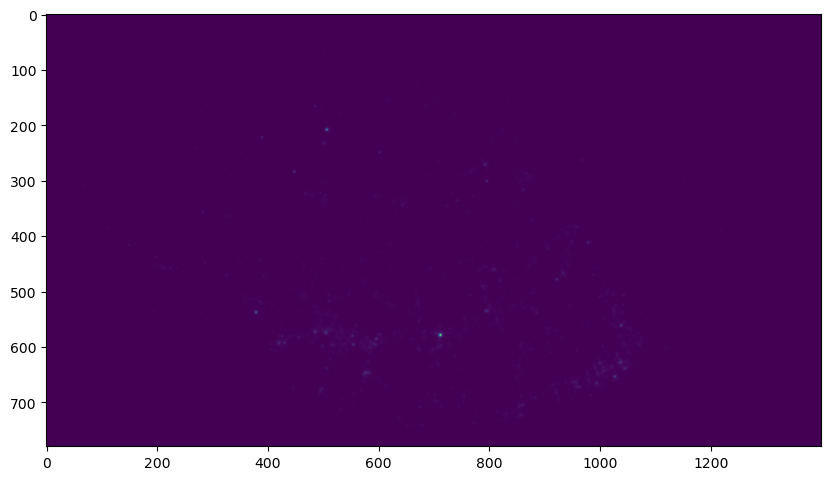

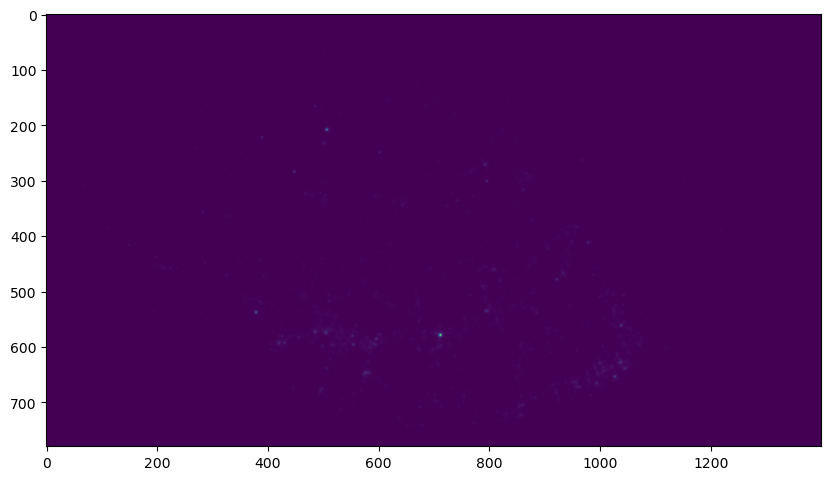

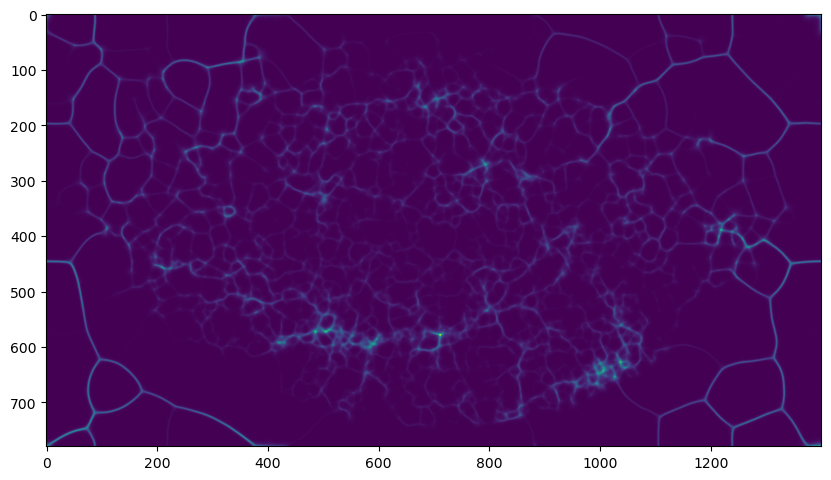

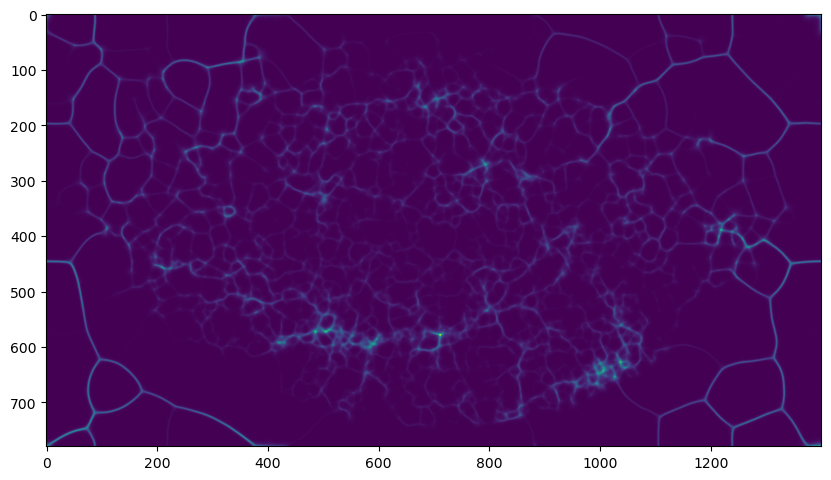

In [15]:
## Plot results
## Compare with stored fields
current_stamp, deposit, trace = store_fit()

plt.figure(figsize = (10.0, 10.0))
plt.imshow(np.flip(np.transpose(deposit[:,:,0]), axis=0))
plt.figure(figsize = (10.0, 10.0))
deposit_restored = np.load(ROOT + 'data/fits/deposit_' + current_stamp + '.npy')
plt.imshow(np.flip(np.transpose(deposit_restored[:,:,0]), axis=0))

plt.figure(figsize = (10.0, 10.0))
plt.imshow(np.flip(np.transpose(trace[:,:,0]), axis=0))
plt.figure(figsize = (10.0, 10.0))
trace_restored = np.load(ROOT + 'data/fits/trace_' + current_stamp + '.npy')
plt.imshow(np.flip(np.transpose(trace_restored[:,:,0]), axis=0))